In [69]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\naras\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading the FakeNews Datasets into pandas dataframe

In [70]:
import os
FakeNews_path = r'Dataset\FakeNews'

#Loading the FakeNews Dataset
politifact_fake = pd.read_csv(os.path.join(FakeNews_path, 'politifact_fake.csv'))
politifact_real = pd.read_csv(os.path.join(FakeNews_path, 'politifact_real.csv'))
gossipcop_fake = pd.read_csv(os.path.join(FakeNews_path, 'gossipcop_fake.csv'))
gossipcop_real = pd.read_csv(os.path.join(FakeNews_path, 'gossipcop_real.csv'))

## Preprocessing: Combine real and fake news into single dataframe

In [71]:
# 0 indicates fake news
# 1 indicates real news
politifact_fake['label'] = 0
politifact_real['label'] = 1  
gossipcop_fake['label'] = 0 
gossipcop_real['label'] = 1  

news_data = pd.concat([politifact_fake, politifact_real, gossipcop_fake, gossipcop_real], ignore_index=True)

print(news_data.head())

                id                                           news_url  \
0  politifact15014          speedtalk.com/forum/viewtopic.php?t=51650   
1  politifact15156  politics2020.info/index.php/2018/03/13/court-o...   
2  politifact14745  www.nscdscamps.org/blog/category/parenting/467...   
3  politifact14355  https://howafrica.com/oscar-pistorius-attempts...   
4  politifact15371  http://washingtonsources.org/trump-votes-for-d...   

                                               title  \
0  BREAKING: First NFL Team Declares Bankruptcy O...   
1  Court Orders Obama To Pay $400 Million In Rest...   
2  UPDATE: Second Roy Moore Accuser Works For Mic...   
3         Oscar Pistorius Attempts To Commit Suicide   
4        Trump Votes For Death Penalty For Being Gay   

                                           tweet_ids  label  
0  937349434668498944\t937379378006282240\t937380...      0  
1  972666281441878016\t972678396575559680\t972827...      0  
2  929405740732870656\t929439450400264

## Preprocessing: Tokenizing the text data and removing the stopwords. Also converting text into sequences of word indices.

In [72]:
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

news_data['processed_text'] = news_data['title'].apply(preprocess_text)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(news_data['processed_text'])
sequences = tokenizer.texts_to_sequences(news_data['processed_text'])
word_index = tokenizer.word_index

X_news = pad_sequences(sequences, maxlen=100)
y_news = news_data['label'].values

## Preprocessing: Converting the sequences into PyTorch Tensors

In [73]:
import torch
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_news_tensor = torch.tensor(X_news, dtype=torch.long)
y_news_tensor = torch.tensor(y_news, dtype=torch.long)

dataset = TensorDataset(X_news_tensor, y_news_tensor)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

Train size: 16237, Validation size: 3479, Test size: 3480


## Defining LSTM model

In [74]:
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, 128)
        self.lstm = nn.LSTM(128, hidden_dim, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = self.fc(x[:, -1, :])
        x = self.sigmoid(x)
        return x

## Defining the Training and Evaluation Function

In [75]:
def train_and_evaluate_model(params, train_loader, val_loader, epochs=5):
    model = LSTMModel(input_dim=params['input_dim'], hidden_dim=params['hidden_dim'], output_dim=1).to(device)
    criterion = nn.BCELoss()
    optimizer = params['optimizer'](model.parameters(), lr=params['learning_rate'])
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            predicted = (y_pred.squeeze() > 0.5).int()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred.squeeze(), y_batch.float())
                val_loss += loss.item()
                predicted = (y_pred.squeeze() > 0.5).int()
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)

        print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}")

    return model, train_losses, val_losses, train_accuracies, val_accuracies

## Using Hyperparameter grid to perform hyperparameter tuning

In [76]:
param_grid = {
    'input_dim': [5000],
    'hidden_dim': [64, 128],
    'learning_rate': [0.001, 0.0001],
    'optimizer': [optim.Adam, optim.RMSprop],
}
grid = ParameterGrid(param_grid)

## Training and Evaluating with Hyperparameter Tuning

In [77]:
best_val_accuracy = 0
best_model = None
best_params = None

for params in grid:
    print(f"Training with params: {params}")
    model, train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(params, train_loader, val_loader, epochs=10)
    print("\n\n")
    if max(val_accuracies) > best_val_accuracy:
        best_val_accuracy = max(val_accuracies)
        best_model = model
        best_params = params

print(f"Best Validation Accuracy: {best_val_accuracy}")
print(f"Best Hyperparameters: {best_params}")

Training with params: {'hidden_dim': 64, 'input_dim': 5000, 'learning_rate': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}


C:\Python311\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Train Loss: 0.4986052696160444, Val Loss: 0.4472844633189115, Train Acc: 0.7675679004742255, Val Acc: 0.8031043403276804
Epoch 2, Train Loss: 0.37797984187527905, Val Loss: 0.4048241263086146, Train Acc: 0.838886493810433, Val Acc: 0.8215004311583789
Epoch 3, Train Loss: 0.3167530722388132, Val Loss: 0.4062165468931198, Train Acc: 0.8683254295744288, Val Acc: 0.8174762862891636
Epoch 4, Train Loss: 0.26486334014009305, Val Loss: 0.4215282957662236, Train Acc: 0.8916671798977643, Val Acc: 0.8157516527737856
Epoch 5, Train Loss: 0.2177422413323808, Val Loss: 0.46660619215531784, Train Acc: 0.9134076491962801, Val Acc: 0.8146018970968669
Epoch 6, Train Loss: 0.17424737093016857, Val Loss: 0.5090376499024305, Train Acc: 0.9317607932499846, Val Acc: 0.8157516527737856
Epoch 7, Train Loss: 0.13537131717765893, Val Loss: 0.5676164337179878, Train Acc: 0.9476504280347354, Val Acc: 0.8146018970968669
Epoch 8, Train Loss: 0.10159861360214592, Val Loss: 0.6576996578411622, Train Acc: 0.9

## Plotting accuracy and loss

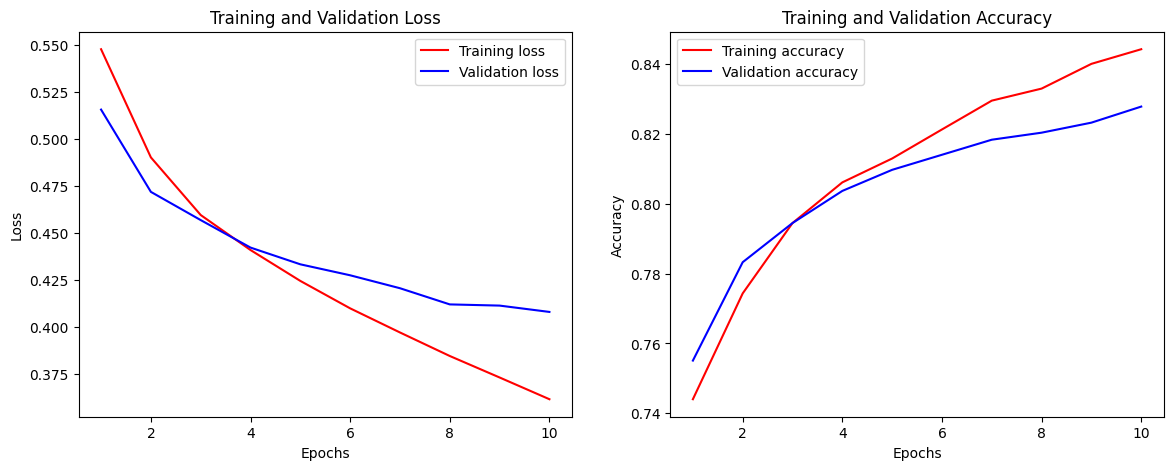

In [78]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

## Evaluation with the Best Model on Test Data

Test Accuracy: 0.8181034482758621
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.60      0.62       847
           1       0.87      0.89      0.88      2633

    accuracy                           0.82      3480
   macro avg       0.75      0.74      0.75      3480
weighted avg       0.81      0.82      0.82      3480



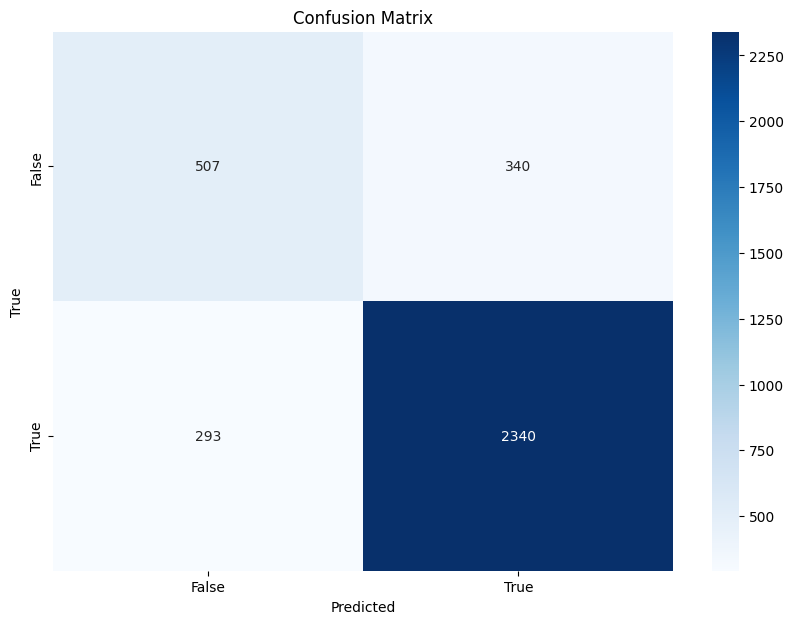

In [80]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the best model on the test set
accuracy, cm, cr = evaluate_model(best_model, test_loader)
print("Test Accuracy:", accuracy)
print("Classification Report:\n", cr)

# Plot the confusion matrix
plot_confusion_matrix(cm, labels=['False', 'True'])

In [81]:
torch.save(best_model.state_dict(), 'best_model.pth')

## Saving the tokenizer to use in the webapp

In [82]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [84]:
input_dim = len(word_index) + 1

In [85]:
input_dim

16709

In [86]:
with open('Webapp/tokenizer.pickle', 'rb') as f:
    tok = pickle.load(f)

In [87]:
tok

In [89]:
len(tok.word_index)

16708